This notebook is an illustration of transfer learning. It uses:
- a pre-trained Model from Keras (Xception)
- a dataset of casting products, some of which have a defect
Then it adds a simple classification layer to the pre-trained model, and trains it with the pictures.

The code is adapted from: 
- Keras tutorial https://keras.io/guides/transfer_learning/
- Kaggle tutorial https://www.kaggle.com/code/digantdixit/transfer-learning-cnn-for-beginners

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, os
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential

In [3]:
train_data_gen = image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="training",
)
test = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


In [4]:
print(train.class_indices)
print(test.class_indices)

{'def_front': 0, 'ok_front': 1}
{'def_front': 0, 'ok_front': 1}


In [5]:
from tensorflow.keras.applications import Xception

xcept = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

In [6]:
# Alternative code to build the transfer model, adapted from Kaggle
# for layer in xcept.layers:
#    layer.trainable = False
# model=keras.Sequential([
#    xcept,
#    keras.layers.Flatten(),
#    keras.layers.Dense(units=256, activation="relu"),
#    keras.layers.Dropout(0.2),
#    keras.layers.Dense(units=1, activation="sigmoid"),
# ])

# model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
# Adapted code from Keras transfer learning tutorial
xcept.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = xcept(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [8]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [9]:
model.fit(
    train,
    epochs=10,
    steps_per_epoch=7,
    validation_data=test,
    validation_steps=len(test),
)

Epoch 1/10
7/7 [==============================] - 81s 10s/step - loss: 0.6487 - accuracy: 0.6295 - val_loss: 0.6450 - val_accuracy: 0.6023
Epoch 2/10
7/7 [==============================] - 46s 7s/step - loss: 0.5996 - accuracy: 0.6161 - val_loss: 0.5710 - val_accuracy: 0.6100
Epoch 3/10
7/7 [==============================] - 47s 7s/step - loss: 0.5371 - accuracy: 0.6786 - val_loss: 0.5445 - val_accuracy: 0.6950
Epoch 4/10
7/7 [==============================] - 42s 6s/step - loss: 0.5312 - accuracy: 0.7033 - val_loss: 0.5256 - val_accuracy: 0.7259
Epoch 5/10
7/7 [==============================] - 44s 7s/step - loss: 0.4814 - accuracy: 0.7902 - val_loss: 0.5092 - val_accuracy: 0.7490
Epoch 6/10
7/7 [==============================] - 47s 7s/step - loss: 0.4881 - accuracy: 0.7812 - val_loss: 0.5006 - val_accuracy: 0.7413
Epoch 7/10
7/7 [==============================] - 42s 7s/step - loss: 0.4907 - accuracy: 0.7411 - val_loss: 0.4871 - val_accuracy: 0.7297
Epoch 8/10
7/7 [=================

In [10]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


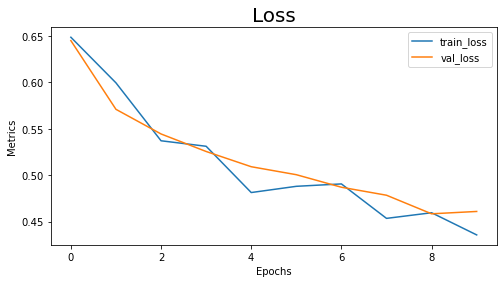

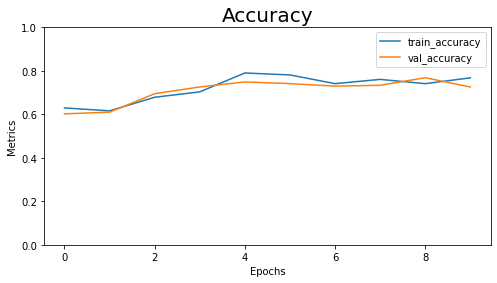

In [11]:
# plot loss
plt.subplots(figsize=(8, 4))
X = range(1, 1 + len(model.history.epoch))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Loss", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels=["train_loss", "val_loss"])
plt.show()

# plot accuracy
plt.subplots(figsize=(8, 4))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.ylim(0, 1)
plt.legend(labels=["train_accuracy", "val_accuracy"])
plt.show()

Ideas of possible variations to see how performance changes:
- try using data augmentation
- try using fine-tuning
- try other pretrained models (resnet, mobilenet)
- try a lower number of input images 




Alternative idea: if we don't want to use transfer learning, we can also use raw classifications from the pre-trained model as a proxy metric to ok/defect

In [12]:
# Incomplete code, To finish - zero-shot prediction on all images to see what comes out
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import numpy as np

model = Xception(input_shape=(299, 299, 3), weights="imagenet")

img_path = "casting_512x512/ok_front/cast_ok_0_1018.jpeg"
# img_path = 'casting_512x512/def_front/cast_def_0_0.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print("Predicted:", decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 938ms/step
Predicted: [('n03843555', 'oil_filter', 0.31126547), ('n04553703', 'washbasin', 0.22433704), ('n04019541', 'puck', 0.09062061)]


: 